## Predição do preço de fechamento de um ativo com LSTM

O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em `n` dias (`window_forward`), tendo como base os `m` dias anteriores (`window_back`).

Para esse estudo foi selecionado o índice do Dólar, visto que é um ativo que possui um comportamento mais definido e menos sensível à variações do mercado.

O modelo será criado a partir do conceito de Previsão univalorada, ou seja, utilizando somente do valor do fechamento diário do ativo.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import Dropout
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [ ]:
# Constantes de períodos
window_back = 40
window_forward = 5
num_periods = 20

In [ ]:
# Abrir o .csv com os dados do ativo
df = pd.read_csv('/content/dol_dataset.csv')

# Fixar Date como index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Manter somente a coluna Close
df = df['Close']

df.head()

Date
2018-08-02    3748
2018-08-03    3705
2018-08-05    3702
2018-08-06    3734
2018-08-07    3750
Name: Close, dtype: int64

In [ ]:
# Verificar o tamanho da base
len(df)

985

### Visualizando os dados

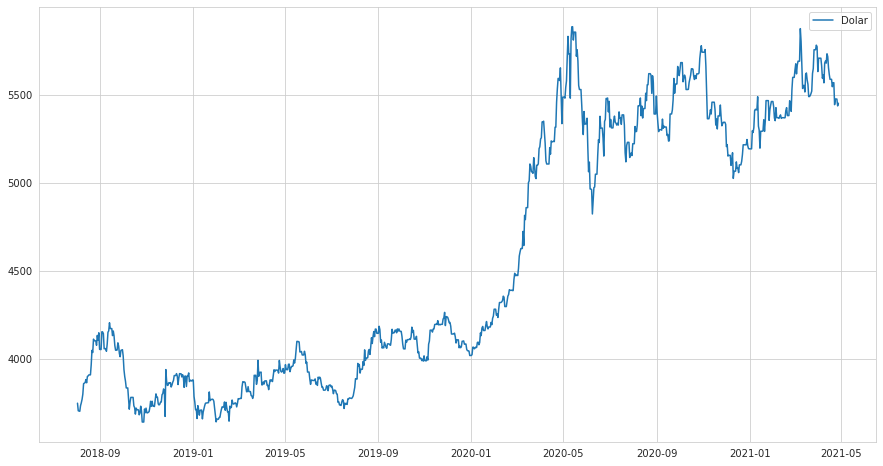

In [ ]:
# Plotar o gráfico com a série histórica do ativo
sns.set_style("whitegrid")
plt.figure(figsize = (15,8))
plt.plot(df, label='Dolar')
plt.legend(loc='best')
plt.show()

### Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste
Vamos separar para os últimos `k` períodos (`num_periods`) para testar o modelo. A cada período, o modelo irá prever os próximos `n` dias. O restante será utilizado para o treinamento (Treino e Validação).

In [ ]:
# Normalização dos dados com o método MinMax
array = df.values.reshape(df.shape[0],1)
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.04764025],
       [0.0284951 ],
       [0.02715939],
       [0.04140695],
       [0.04853072]])

In [ ]:
# Divisão entre Treinamento e Teste
division = len(array) - num_periods*window_forward

array_test = array[division-window_back:]
array_train = array[:division]

In [ ]:
# Divisão dos dados de entrada X e saída Y
def processData(data, window_back, window_forward, jump=1):
    X,Y = [],[]
    for i in range(0, len(data) - window_back - window_forward + 1, jump):
        X.append(data[i:(i + window_back)])
        Y.append(data[(i + window_back):(i + window_back + window_forward)])
    return np.array(X), np.array(Y)

In [ ]:
X_test, y_test = processData(array_test, window_back, window_forward, window_forward)
y_test = np.array([list(a.ravel()) for a in y_test])

X, y = processData(array_train, window_back, window_forward)
y = np.array([list(a.ravel()) for a in y])

# Divisão entre Treinamento/Validação 80:20
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Mostrar o shape dos vetores de treino, validação e teste
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(672, 40, 1)
(169, 40, 1)
(20, 40, 1)
(672, 5)
(169, 5)
(20, 5)


## Criando o modelo LSTM

In [ ]:
# Definição no número de épocas a treinar
EPOCHS = 50

# Criar camadas do modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape = (window_back, 1), return_sequences=True))
model.add(LSTM(32, input_shape = (64, 1)))
model.add(Dense(window_forward))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 29,477
Trainable params: 29,477
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_validate, y_validate), shuffle=True, batch_size=2, verbose=2)

Epoch 1/50
336/336 - 10s - loss: 0.0116 - val_loss: 0.0052
Epoch 2/50
336/336 - 6s - loss: 0.0035 - val_loss: 0.0025
Epoch 3/50
336/336 - 6s - loss: 0.0031 - val_loss: 0.0024
Epoch 4/50
336/336 - 6s - loss: 0.0030 - val_loss: 0.0034
Epoch 5/50
336/336 - 6s - loss: 0.0025 - val_loss: 0.0024
Epoch 6/50
336/336 - 6s - loss: 0.0022 - val_loss: 0.0019
Epoch 7/50
336/336 - 6s - loss: 0.0025 - val_loss: 0.0018
Epoch 8/50
336/336 - 6s - loss: 0.0020 - val_loss: 0.0015
Epoch 9/50
336/336 - 6s - loss: 0.0019 - val_loss: 0.0018
Epoch 10/50
336/336 - 6s - loss: 0.0021 - val_loss: 0.0016
Epoch 11/50
336/336 - 6s - loss: 0.0019 - val_loss: 0.0016
Epoch 12/50
336/336 - 6s - loss: 0.0017 - val_loss: 0.0012
Epoch 13/50
336/336 - 6s - loss: 0.0017 - val_loss: 0.0015
Epoch 14/50
336/336 - 6s - loss: 0.0015 - val_loss: 0.0011
Epoch 15/50
336/336 - 6s - loss: 0.0016 - val_loss: 0.0015
Epoch 16/50
336/336 - 6s - loss: 0.0015 - val_loss: 0.0023
Epoch 17/50
336/336 - 6s - loss: 0.0015 - val_loss: 0.0018
Epoch

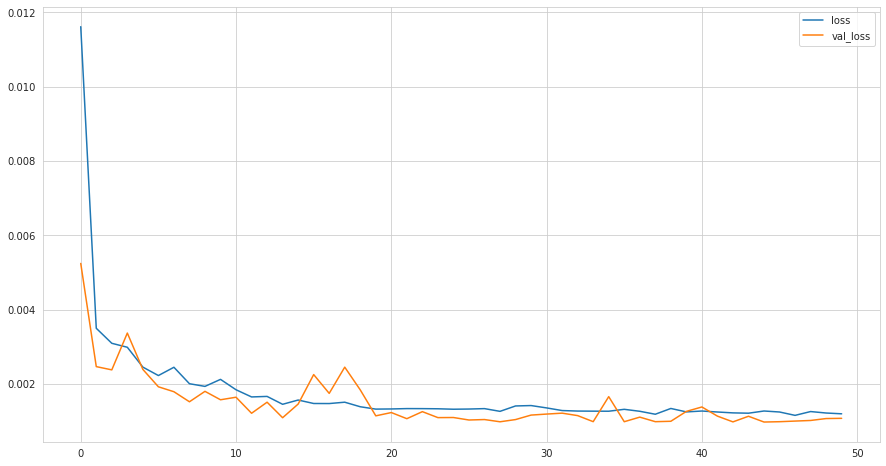

In [ ]:
# Gráfico comparativo de loss
plt.figure(figsize = (15,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

### Resultados do modelo criado


In [ ]:
# Predição do modelo
Xt = model.predict(X_test)

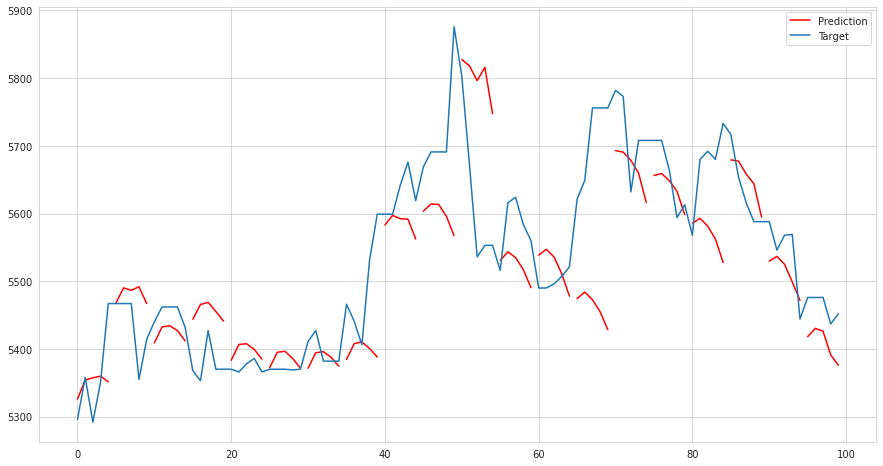

In [ ]:
# Plotando o resultado do modelo na base de teste
plt.figure(figsize = (15,8))

for i in range(0,len(Xt)):
    plt.plot([x + i*window_forward for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction')
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

O gráfico acima mostra uma previsão dos valores do ativo para 5 dias a frente (`window_forward`), tendo como base os últimos 40 dias (`window_back`). As linhas vermelhas representam os períodos previstos pelo modelo (`num_periods`).

### Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste

In [ ]:
division = len(array) - num_periods*window_forward

leftover = division%window_forward+1

array_test = array[division-window_back:]
array_train = array[leftover:division]

In [ ]:
Xtrain,ytrain = processData(array_train,window_back,window_forward,window_forward)
Xtest,ytest = processData(array_test,window_back,window_forward,window_forward)

In [ ]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [ ]:
y = np.concatenate((ytrain, ytest), axis=0)

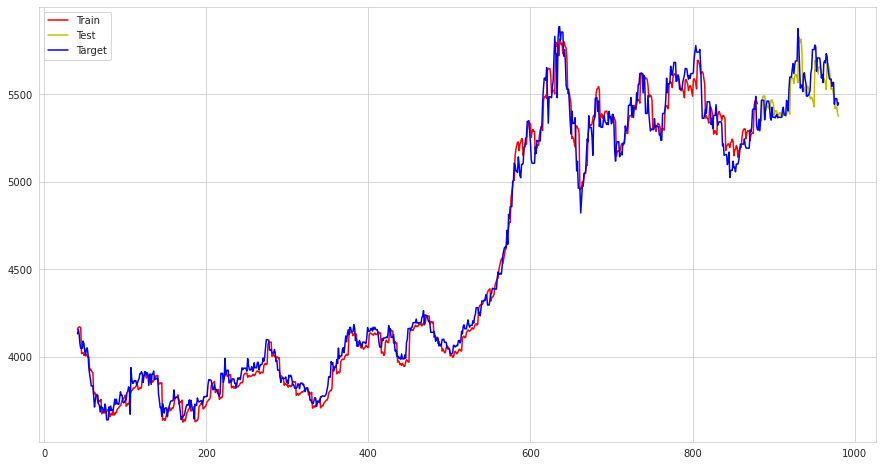

In [ ]:
# Dados em Trainamento/Validação
plt.figure(figsize = (15,8))
plt.plot([x for x in range(window_back+leftover, len(Xtrain)+window_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')

# Dados em teste
plt.plot([x for x in range(window_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+window_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

# Dados utilizados
plt.plot([x for x in range(window_back+leftover, window_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

plt.legend(loc='best')
plt.show()

### Conclusão

Em se tratando de ativos do mercado financeiro, mesmo escolhendo um ativo com um comportamento menos sensível, o resultado utilizando somente um modelo LSTM univalorado não é o suficiente para predizer o comportamento do ativo. Existem muitas variáveis que influenciam os preços dos ativos, sejam do cenário nacional quanto internacional.

**Referência: https://medium.com/infosimples/predicting-stock-prices-with-lstm-349f5a0974d4**